<a href="https://colab.research.google.com/github/Robinjean/Project_Covid19_Fake_news_detection_using_RNN_LSTM_GRU_transformers/blob/main/Covid19_fake_news_detection_using_BERT_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
#from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

#Load datasets

In [3]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset files
train_path = '/content/drive/My Drive/AMMI_FINAL_RESEARCH_PROJECT/Covid_fake_news/Constraint_English_Train - Sheet1.csv'
val_path = '/content/drive/My Drive/AMMI_FINAL_RESEARCH_PROJECT/Covid_fake_news/Constraint_English_Val - Sheet1.csv'
test_path = '/content/drive/My Drive/AMMI_FINAL_RESEARCH_PROJECT/Covid_fake_news/english_test_with_labels - Sheet1.csv'

# Load datasets
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

Mounted at /content/drive


In [4]:
df = pd.concat([train_df,val_df, test_df])

In [5]:
df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [6]:
# Map labels to numerical values
label_mapping = {'real': 1, 'fake': 0}
df['label'] = df['label'].map(label_mapping)

In [7]:
df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,1
1,2,States reported 1121 deaths a small rise from ...,1
2,3,Politically Correct Woman (Almost) Uses Pandem...,0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,1
4,5,Populous states can generate large case counts...,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10700 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10700 non-null  int64 
 1   tweet   10700 non-null  object
 2   label   10700 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 334.4+ KB


In [9]:
df['label'].value_counts() #===> the data is imbalaced

label
1    5600
0    5100
Name: count, dtype: int64

#Data Preprocessing

Lowercasing

In [10]:
df['lower_text'] = df['tweet'].str.lower()
df['lower_text']

0       the cdc currently reports 99031 deaths. in gen...
1       states reported 1121 deaths a small rise from ...
2       politically correct woman (almost) uses pandem...
3       #indiafightscorona: we have 1524 #covid testin...
4       populous states can generate large case counts...
                              ...                        
2135    #coronavirusupdates: state-wise details of tot...
2136    tonight 12(midnight) onwards disaster manageme...
2137    296 new cases of #covid19nigeria; plateau-85 e...
2138    rt @cdcemergency: #dyk? @cdcgov’s one-stop sho...
2139    more than half of pregnant women recently admi...
Name: lower_text, Length: 10700, dtype: object

 Removing URLs and special characters

In [11]:
df['text'] = df['lower_text'].apply(lambda x: re.sub(r'http\S+', ' ', x))
df['text'] = df['lower_text'].apply(lambda x: re.sub(r'\S*@\S*\s?', ' ', x))
df['text'] = df['lower_text'].apply(lambda x: re.sub(r'\s+', ' ', x))
df['text'] = df['lower_text'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

In [12]:
df['text']

0       the cdc currently reports 99031 deaths  in gen...
1       states reported 1121 deaths a small rise from ...
2       politically correct woman  almost  uses pandem...
3        indiafightscorona  we have 1524  covid testin...
4       populous states can generate large case counts...
                              ...                        
2135     coronavirusupdates  state wise details of tot...
2136    tonight 12 midnight  onwards disaster manageme...
2137    296 new cases of  covid19nigeria  plateau 85 e...
2138    rt  cdcemergency   dyk   cdcgov s one stop sho...
2139    more than half of pregnant women recently admi...
Name: text, Length: 10700, dtype: object

Removing stopwords

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
stop_words = stopwords.words('english')

In [15]:
extra = extra = ['https','t','co']

Adding the elements of extra to the stopwords

In [16]:
for c in extra:
  stop_words.append(c)

In [17]:
df['text_clean'] = df['text'].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))

In [18]:
df['text_clean']

0       cdc currently reports 99031 deaths general dis...
1       states reported 1121 deaths small rise last tu...
2       politically correct woman almost uses pandemic...
3       indiafightscorona 1524 covid testing laborator...
4       populous states generate large case counts loo...
                              ...                        
2135    coronavirusupdates state wise details total co...
2136    tonight 12 midnight onwards disaster managemen...
2137    296 new cases covid19nigeria plateau 85 enugu ...
2138    rt cdcemergency dyk cdcgov one stop shop covid...
2139    half pregnant women recently admitted uk hospi...
Name: text_clean, Length: 10700, dtype: object

Lemmatization

In [19]:
import nltk
from nltk.stem import WordNetLemmatizer

In [20]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [21]:
# Function to perform lemmatization on text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

In [22]:
# Apply lemmatization to the 'text' column
df['text_clean'] = df['text_clean'].apply(lambda x: lemmatize_text(x))

In [23]:
df['text_clean']

0       cdc currently report 99031 death general discr...
1       state reported 1121 death small rise last tues...
2       politically correct woman almost us pandemic e...
3       indiafightscorona 1524 covid testing laborator...
4       populous state generate large case count look ...
                              ...                        
2135    coronavirusupdates state wise detail total con...
2136    tonight 12 midnight onwards disaster managemen...
2137    296 new case covid19nigeria plateau 85 enugu 4...
2138    rt cdcemergency dyk cdcgov one stop shop covid...
2139    half pregnant woman recently admitted uk hospi...
Name: text_clean, Length: 10700, dtype: object

#Transformer Model BERT


Mixed precision training uses both 16-bit and 32-bit floating-point numbers to speed up training and reduce memory usage

In [24]:
# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [25]:
# Parameters
max_seq_length = 150

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input sequences for both training and testing
def tokenize_and_pad(texts, max_len):
    tokenized_data = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )
    return tokenized_data

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [26]:
# Tokenize and pad sequences
tokenized_train = tokenize_and_pad(df['text_clean'], max_seq_length)

In [27]:
# Convert to numpy arrays
input_ids = tokenized_train['input_ids'].numpy()
attention_masks = tokenized_train['attention_mask'].numpy()

In [28]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['label'])

In [29]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test, attention_masks_train, attention_masks_test = train_test_split(
    input_ids,
    labels,
    attention_masks,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

In [30]:
# Load pre-trained BERT model
model_bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_bert.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [32]:
# Train the model
history_bert = model_bert.fit(
    [x_train, attention_masks_train],
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/20


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x79051b3a2fe0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x79051b3a2fe0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
214/214 [==============================] - 199s 497ms/step - loss: 0.2664 - accuracy: 0.8877 - val_loss: 0.1465 - val_accuracy: 0.9480
Epoch 2/20
214/214 [==============================] - 94s 439ms/step - loss: 0.0906 - accuracy: 0.9638 - val_loss: 0.1100 - val_accuracy: 0.9550
Epoch 3/20
214/214 [==============================] - 92s 430ms/step - loss: 0.0371 - accuracy: 0.9885 - val_loss: 0.1227 - val_accuracy: 0.9644
Epoch 4/20
214/214 [==============================] - 88s 409ms/step - loss: 0.0207 - accuracy: 0.9930 - val_loss: 0.1435 - val_accuracy: 0.9638
Epoch 5/20
214/214 [==============================] - 90s 420ms/step - loss: 0.0142 - accuracy: 0.9955 - val_loss: 0.2583 - val

# Evaluate the model

In [33]:
# Predict on the test set
y_pred_probs = model_bert.predict([x_test, attention_masks_test])
y_pred = np.argmax(y_pred_probs.logits, axis=1)

# Calculate accuracy
accuracy_bert = accuracy_score(y_test, y_pred)
print(f"BERT Test Accuracy: {accuracy_bert * 100:.2f}%")

# Print classification report
print(classification_report(y_test, y_pred))

67/67 [==============================] - 18s 134ms/step
BERT Test Accuracy: 95.61%
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1020
           1       0.97      0.95      0.96      1120

    accuracy                           0.96      2140
   macro avg       0.96      0.96      0.96      2140
weighted avg       0.96      0.96      0.96      2140



#Visualizing Training and Validation Accuracy

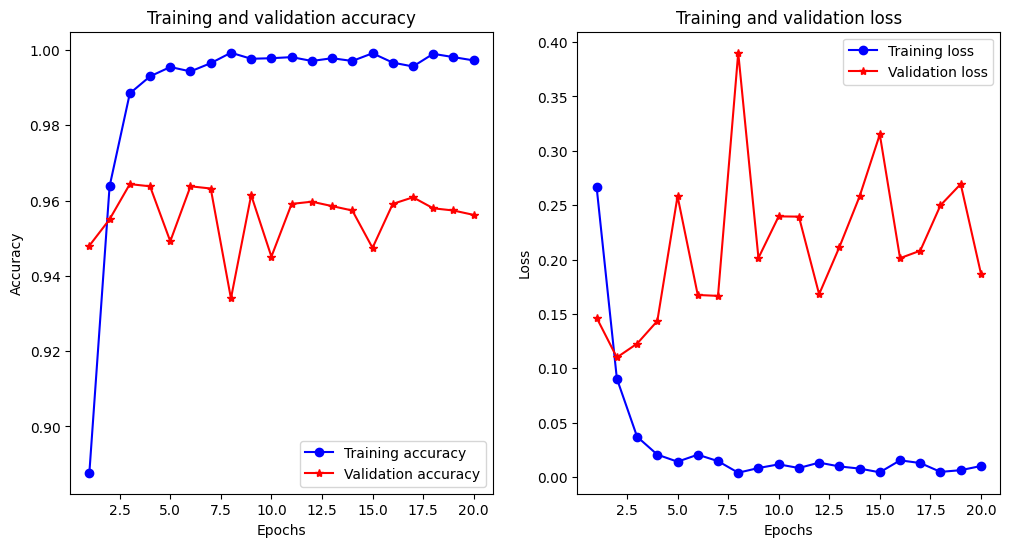

In [34]:
history_dict = history_bert.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()